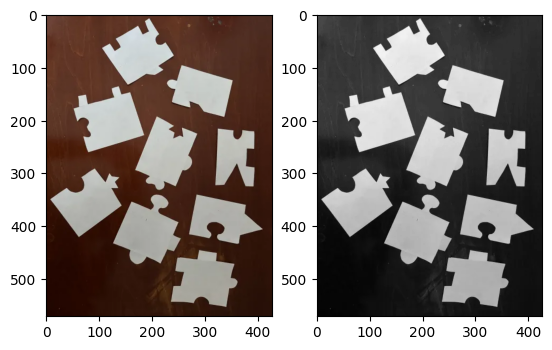

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

unsolved = cv2.imread("./easy_puzzle.png")
unsolved = cv2.cvtColor(unsolved, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(unsolved, cv2.COLOR_BGR2GRAY)
plt.subplot(1, 2, 1)
plt.imshow(unsolved)
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')

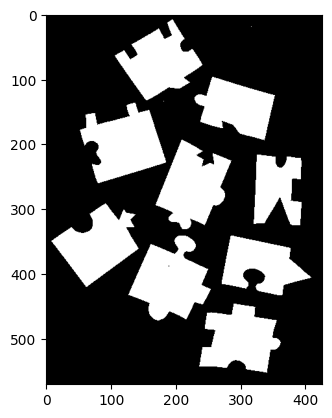

In [2]:
_, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap='gray')

In [3]:
class Piece:
    def __init__(self, pixel_coords, outline_coords):
        self.pixel_coords = pixel_coords
        self.outline_coords = outline_coords
        self.center = self.calculate_center_pos()
    
    def calculate_center_pos(self):
        # Calculates center relative to original image
        x_cum = y_cum = 0
        for x, y in self.pixel_coords:
            x_cum += x
            y_cum += y
        return int(y_cum / len(self.pixel_coords)), int(x_cum / len(self.pixel_coords))

    def image(self, return_piece=False):
        x_min, x_max = min(i[0] for i in self.outline_coords), max(i[0] for i in self.outline_coords)
        y_min, y_max = min(i[1] for i in self.outline_coords), max(i[1] for i in self.outline_coords)
        image = np.ones((x_max - int(x_min * 0.4), y_max - int(y_min * 0.4))) * 255
        for pt in self.pixel_coords:
            image[pt[1]  - int(x_min * 0.8), pt[0] - int(y_min * 0.8)] = 0
        image = image.astype(np.uint8)
        return image
    
    def show(self):
        plt.imshow(self.image(), cmap='gray')
    
    

In [4]:
def find_pieces(thresholded_image, pixel_thresh, puzzle_color=255, background_color=0):
    pieces = []
    width = len(thresholded_image[0])
    height = len(thresholded_image)
    visited = [[False for _ in range(width)] for __ in range(height)]

    def dfs(i, j):
        num_pixels = 0
        st = [[i, j]]
        piece_coords = []
        outline_coords = set()
        while len(st) != 0:
            curr_i, curr_j = st.pop()
            piece_coords.append((curr_i, curr_j))
            num_pixels += 1
            visited[curr_i][curr_j] = True
            for n in neighbors(curr_i, curr_j):
                if thresholded_image[n[0]][n[1]] == puzzle_color and not visited[n[0]][n[1]]:
                    st.append(n)
                if thresholded_image[n[0]][n[1]] == background_color:
                    outline_coords.add(tuple(n[::-1]))
        return Piece(piece_coords, outline_coords), num_pixels

    def neighbors(i, j):
        n = []
        if i > 0:
            n.append([i - 1, j])
        if i < height - 1:
            n.append([i + 1, j])
        if j > 0:
            n.append([i, j - 1])
        if j < width - 1:
            n.append([i, j + 1])
        return n
    
    for i in range(height):
        for j in range(width):
            if not visited[i][j] and thresholded_image[i][j] == puzzle_color:
                piece, num_pixels = dfs(i, j)
                if num_pixels > pixel_thresh:
                    pieces.append(piece)
    return pieces

In [5]:
pieces = find_pieces(thresholded_image=thresholded, pixel_thresh=100)

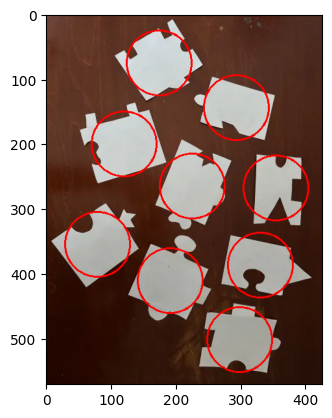

In [6]:
circled_image = unsolved.copy()
for piece in pieces:
    circled_image = cv2.circle(circled_image, piece.center, 50, (255, 0, 0), 2)
plt.imshow(circled_image)

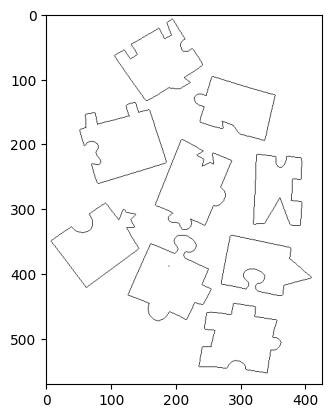

In [7]:
outline_image = np.ones_like(unsolved) * 255
for piece in pieces:
    for pt in piece.outline_coords:
        outline_image = cv2.circle(outline_image, pt, 0, (0, 0, 0), 1)
plt.imshow(outline_image)

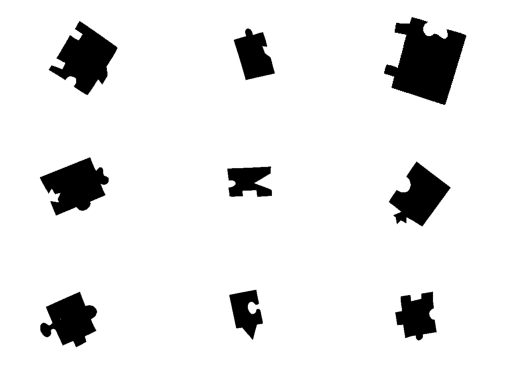

In [8]:
for pl in range(1, 10):
    plt.subplot(3, 3, pl)
    plt.axis('off')
    pieces[pl - 1].show()

In [9]:
from itertools import combinations
import math

vector_subtract = lambda a, b: (a[0] - b[0], a[1] - b[1])
vector_mag = lambda a: (a[0]**2 + a[1]**2)**0.5
vector_dot = lambda a, b: a[0] * b[0] + a[1] * b[1]

def calculate_centroid(p1, p2, p3, p4):
    return ((p1[0] + p2[0] + p3[0] + p4[0]) / 4, (p1[1] + p2[1] + p3[1] + p4[1]) / 4)

def sort_points(points):
    centroid = calculate_centroid(*points)
    sorted_points = sorted(points, key=lambda p: math.atan2(p[1] - centroid[1], p[0] - centroid[0]))
    return sorted_points

def check_rectangle(sorted_points, angle_thresh=0.1):
    p1, p2, p3, p4 = sorted_points
    v1, v2 = vector_subtract(p2, p1), vector_subtract(p4, p1)
    v3, v4 = vector_subtract(p2, p3), vector_subtract(p4, p3)
    angle_1 = math.acos(vector_dot(v1, v2) / (vector_mag(v1) * vector_mag(v2)))
    angle_2 = math.acos(vector_dot(v3, v4) / (vector_mag(v3) * vector_mag(v4)))
    return abs(angle_1 - math.pi / 2) < angle_thresh and abs(angle_2 - math.pi / 2) < angle_thresh

def calculate_area(p1, p2, p3, p4):
    # Shoelace formula
    p1, p2, p3, p4 = sort_points([p1, p2, p3, p4])
    return 0.5 * abs(p1[0]*p2[1] + p2[0]*p3[1] + p3[0]*p4[1] + p4[0]*p1[1] -
                     p1[1]*p2[0] - p2[1]*p3[0] - p3[1]*p4[0] - p4[1]*p1[0])

def find_largest_rectangle(points):
    max_area = 0
    best_rectangle = None
    
    # Iterate over all combinations of 4 points
    for p1, p2, p3, p4 in combinations(points, 4):
        sorted_points = sort_points([p1, p2, p3, p4])
        if check_rectangle(sorted_points):
            area = calculate_area(p1, p2, p3, p4)
            if area > max_area:
                max_area = area
                best_rectangle = (p1, p2, p3, p4)
    
    return best_rectangle, max_area

In [10]:
def detect_piece_corners(piece):
    img = piece.image().astype(np.uint8)
    dst = cv2.cornerHarris(img,5,3,0.04)

    t = dst > (np.mean(dst) + np.std(dst))
    t = t.astype(np.uint8) * 255

    corners = [c.center for c in find_pieces(t, pixel_thresh=10)]

    best_rectangle, _ = find_largest_rectangle(corners)
    return best_rectangle

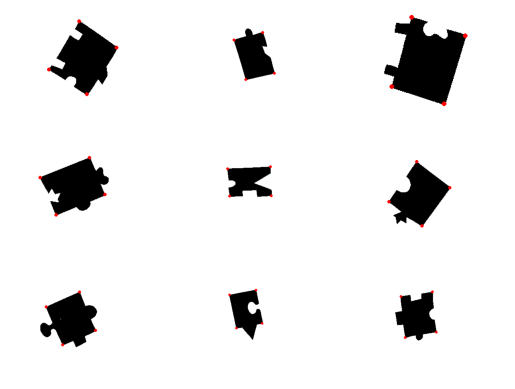

In [11]:
for idx, piece in enumerate(pieces):
    corners = detect_piece_corners(piece)
    corner_image = cv2.cvtColor(piece.image(), cv2.COLOR_GRAY2RGB)
    for pt in corners:
        corner_image = cv2.circle(corner_image, pt, 2, (255, 0, 0), 2)
    plt.subplot(3, 3, idx + 1)
    plt.axis('off')
    plt.imshow(corner_image)

In [12]:
def image_center(piece_image):
    x_cum, y_cum = 0, 0
    num_piece_pixels = 0
    for row in range(len(piece_image)):
        for col in range(len(piece_image[0])):
            if piece_image[row][col] == 0:
                x_cum += row
                y_cum += col
                num_piece_pixels += 1
    return int(x_cum / num_piece_pixels), int(y_cum / num_piece_pixels)

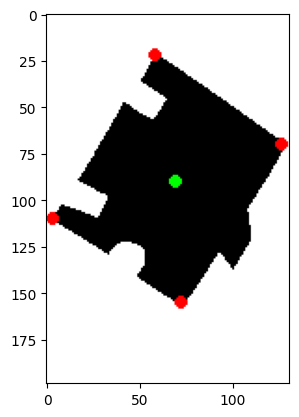

In [13]:
piece_0 = cv2.cvtColor(pieces[0].image(), cv2.COLOR_GRAY2RGB)
piece_0_center = image_center(pieces[0].image())
piece_0_corners = detect_piece_corners(pieces[0])
for pt in piece_0_corners:
    piece_0 = cv2.circle(piece_0, pt, 2, (255, 0, 0), 2)
piece_0 = cv2.circle(piece_0, piece_0_center[::-1], 2, ((0, 255, 0)), 2)
plt.imshow(piece_0)

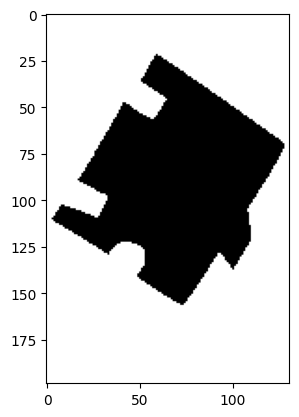

In [14]:
plt.imshow(pieces[0].image(), cmap='gray')

In [15]:
piece = find_pieces(pieces[0].image(), 127, puzzle_color=0, background_color=255)[0]

In [16]:
aligned_pieces = [find_pieces(p.image(), 127, puzzle_color=0, background_color=255)[0] for p in pieces]

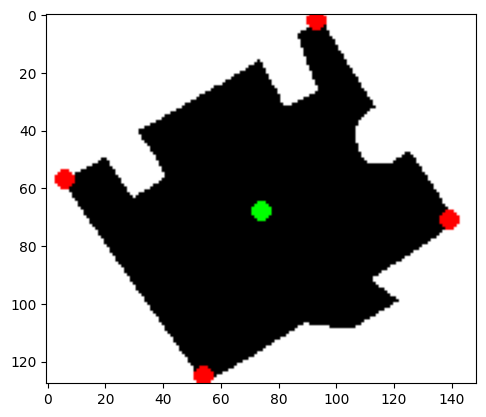

In [17]:
piece_0 = cv2.cvtColor(aligned_pieces[0].image(), cv2.COLOR_GRAY2RGB)
piece_0_center = image_center(aligned_pieces[0].image())
piece_0_corners = detect_piece_corners(aligned_pieces[0])
for pt in piece_0_corners:
    piece_0 = cv2.circle(piece_0, pt, 2, (255, 0, 0), 2)
piece_0 = cv2.circle(piece_0, piece_0_center[::-1], 2, ((0, 255, 0)), 2)
plt.imshow(piece_0)

In [75]:
closest_outline_points = set()
for corner in piece_0_corners:
    closest_point, closest_distance = None, 1e99
    for pt in aligned_pieces[0].outline_coords:
        dist = vector_mag(vector_subtract(pt[::-1], corner))
        if dist <= closest_distance:
            closest_distance = dist
            closest_point = pt
    
    assert closest_point != None
    closest_outline_points.add(closest_point)

In [76]:
# Choice:
# Could do n^2 solution and have each point connect to its nearest two neighbors
# and then cut off the sides when they hit the outline points
# O(n) solution where we just cut the puzzle into 4 pizza slices
# and outline points that fall in the slice belong to the side

[(8, 102), (59, 21), (81, 146), (117, 61)]

In [4]:
import numpy as np

def is_point_between_rays(A, B, C, P):
    """
    Determines if point P lies between rays AB and AC.

    Parameters:
    A, B, C, P (tuple or list): Coordinates of points A, B, C, and P as (x, y).

    Returns:
    bool: True if P is between rays AB and AC, False otherwise.
    """
    def vector_subtract(u, v):
        return [u[i] - v[i] for i in range(len(u))]
    
    def cross_product_2d(u, v):
        return u[0] * v[1] - u[1] * v[0]
    
    # Calculate vectors AB, AC, and AP
    AB = vector_subtract(B, A)
    AC = vector_subtract(C, A)
    AP = vector_subtract(P, A)
    
    # Calculate cross products
    cross1 = cross_product_2d(AB, AP)
    cross2 = cross_product_2d(AC, AP)
    
    # Point P is between the rays if the cross products have opposite signs
    return cross1 * cross2 <= 0

# Example usage
A = (1, 1)
B = (4, 3)
C = (3, 6)
P = (2.5, 3)  # Example point to check

print(is_point_between_rays(A, B, C, P))  # Output: True or False based on P's position


True
